# Data Analysis Interview Challenge

# Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

Aggregate these login counts based on 15 minutes time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

____________________

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
matplotlib.rcParams['figure.figsize']= [15, 5]

Let's read the data first:

In [2]:
logins = pd.read_json("logins.json", orient='values').login_time

In [3]:
logins

0       1970-01-01 20:13:18
1       1970-01-01 20:16:10
2       1970-01-01 20:16:37
3       1970-01-01 20:16:36
4       1970-01-01 20:26:21
                ...        
93137   1970-04-13 18:50:19
93138   1970-04-13 18:43:56
93139   1970-04-13 18:54:02
93140   1970-04-13 18:57:38
93141   1970-04-13 18:54:23
Name: login_time, Length: 93142, dtype: datetime64[ns]

In [4]:
max(logins)

Timestamp('1970-04-13 18:57:38')

In [5]:
min(logins)

Timestamp('1970-01-01 20:12:16')

As we see, all data dated 1970 year, which is unlikely to be true. As 3rd task mention 2014 year, it's save to assume that the year in question is actually 2014. Let's add difference:

In [6]:
logins = logins + pd.offsets.DateOffset(years=44)

Now let's aggregate logins by 15 minutes:

In [7]:
logs_per_15_mins = logins.value_counts().resample('15min').sum()
logs_per_15_mins

2014-01-01 20:00:00    2
2014-01-01 20:15:00    6
2014-01-01 20:30:00    9
2014-01-01 20:45:00    7
2014-01-01 21:00:00    1
                      ..
2014-04-13 17:45:00    5
2014-04-13 18:00:00    5
2014-04-13 18:15:00    2
2014-04-13 18:30:00    7
2014-04-13 18:45:00    6
Freq: 15T, Name: login_time, Length: 9788, dtype: int64

Let's take a look at count plot:

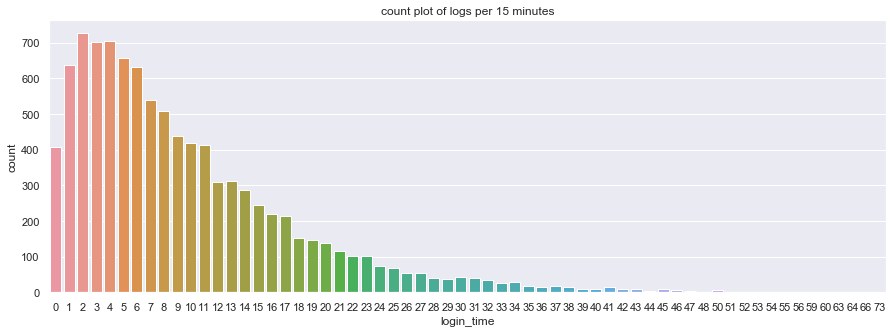

In [9]:
sns.set(style="darkgrid")
sns.countplot(logs_per_15_mins)
plt.title("count plot of logs per 15 minutes")
plt.show()

There are ~400 15-minutes-intervals with no records. It may indicate that data was not collection during this time.

Plot of logins count per 15 mins:

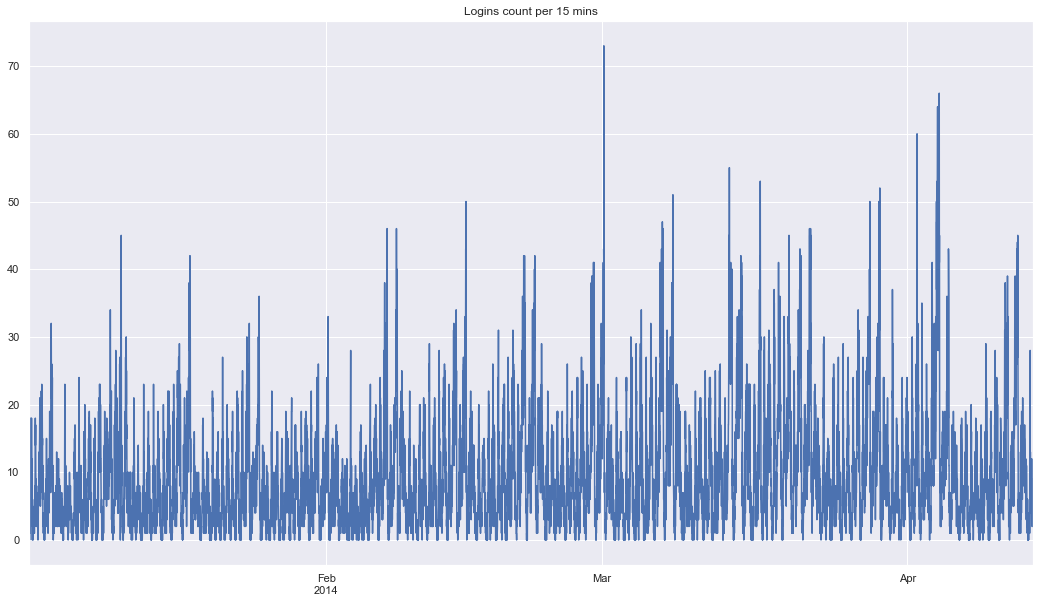

In [15]:
plt.figure(figsize=(18, 10))
logs_per_15_mins.plot(title = "Logins count per 15 mins", grid = True)
plt.show()

As is, plot isn't very informative. We can "zoom" to see separate week:

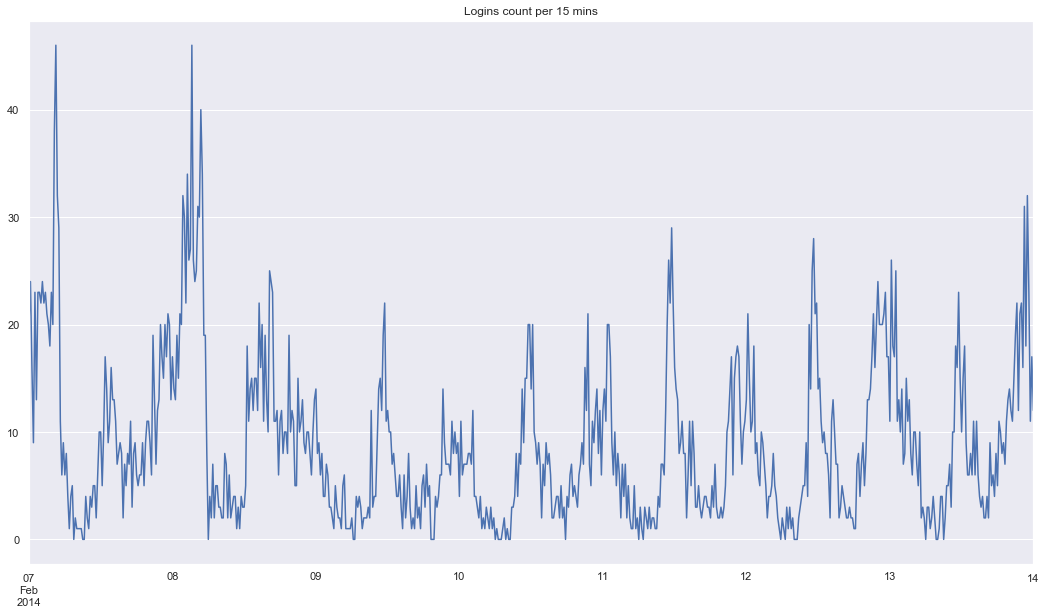

In [18]:
plt.figure(figsize=(18, 10))
start_date = datetime(2014, 2, 7)
end_date = datetime(2014, 2, 14)
logs_per_15_mins[
    (start_date <= logs_per_15_mins.index) & (end_date >= logs_per_15_mins.index)
].plot(title="Logins count per 15 mins")
plt.show()

Separate day:

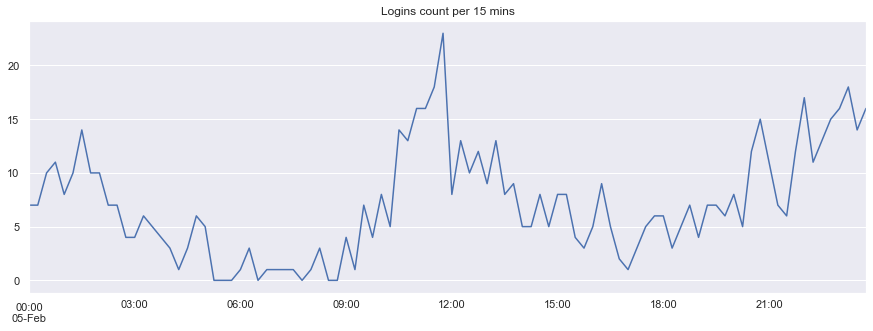

In [19]:
start_date = datetime(2014, 2, 5)
end_date = datetime(2014, 2, 6)
logs_per_15_mins[
    (start_date <= logs_per_15_mins.index) & (end_date > logs_per_15_mins.index)
].plot(title="Logins count per 15 mins")
plt.show()

Let's see logins per day of week:

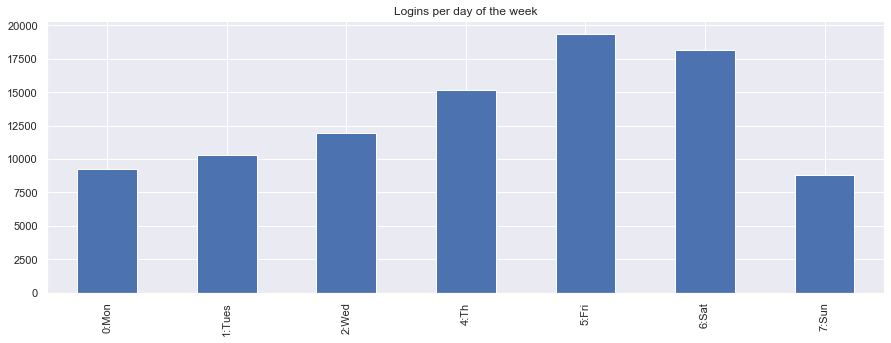

In [21]:
weekDays = ("0:Mon", "1:Tues", "2:Wed", "4:Th", "5:Fri", "6:Sat", "7:Sun")

logins.apply(lambda d: weekDays[d.dayofweek]).value_counts().sort_index().plot(
    kind="bar", title="Logins per day of the week",
)
plt.show()

The most busy day is Friday, followed by Saturday. The leas busy is Sunday. As we move from Sunday to Friday, the trip counts increases.

Logins per hour of the day:

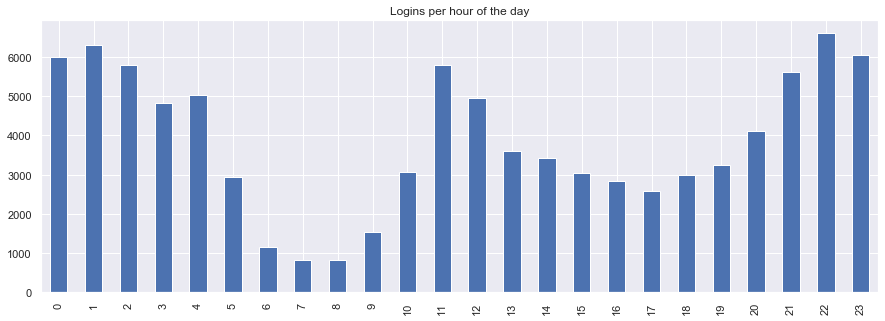

In [23]:
logins.apply(lambda d: d.hour).value_counts().sort_index().plot(
    kind="bar", title="Logins per hour of the day",
)
plt.show()

The least busy periods are 6am to 9 am. The most busy - 21 pm to 4 am; 11 am - 12 pm.

____________

Other way to see trends is to use facebook's prophet library:

In [29]:
#converting to the format pophet needs
df = pd.DataFrame(logs_per_15_mins).reset_index().rename(columns={"index": "ds", "login_time": "y"})

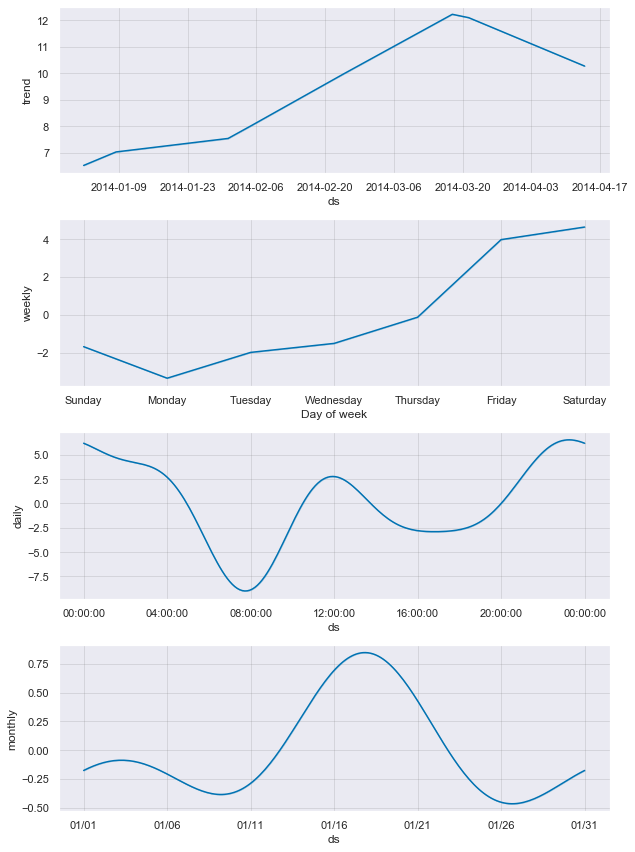

In [31]:
import fbprophet

m = fbprophet.Prophet(yearly_seasonality=False)
m.add_seasonality(name="monthly", period=30.5, fourier_order=3)
m.fit(df)
# Make a future dataframe for 1 h (we use small period, just co convert to the format we need for plotting)
forecast = m.make_future_dataframe(periods=1, freq="h")
# Make predictions
forecast = m.predict(forecast)
fig = m.plot_components(forecast)

It shows upward trend in logins count before May, 18, and downward after that.

Also we can clearly see weekly trend - trips rising Monday to Saturday.

Daily patterns shows peak around midnight, and then around midday.


___________

# Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

     a. how you will implement the experiment 

     b. what statistical test(s) you will conduct to verify the significance of the observation

     c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

___________

1.	The easiest way would be simply to calculate if number of bridge crossing. I would use it because if drivers are crossing the bridge, they are actually moving from one city to other, those, serving both cities. We keep collecting data until we have large enough observations.

2.	We need do use one-side t-test. First group (A) of drivers will keep driving as they were before, the second (B) – will get toll reimbursement. Null hypotheses would be that bridge crossing of   group A is same as for group B. Alternative hypotheses is that bridge crossing of group B is larger than bridge crossing count for drivers of group A. We take a look at p value. If it’s significant, and if we reject null hypotheses and accept alternative, we acknowledge that new approach of toll reimbursements is better and allow to proceed with implementation of reimbursement for all drivers.


______________

# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

### Data description

● city: city this user signed up in
    
● phone: primary device for this user
    
● signup_date: date of account registration; in the form ‘YYYY MM DD’
    
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
    
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    
● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    
● surge_pct: the percent of trips taken with surge multiplier > 1
    
● avg_surge: The average surge multiplier over all of this user’s trips
    
● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

______________

Let's read the data:

In [12]:
df = pd.read_json("ultimate_data_challenge.json", orient='values')

In [13]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We have 8719 null values, located in 3 columns. 

In [15]:
sum(df.isnull().sum())

8719

Here is histogram of avg_rating_of_driver.
It's understandable why there are missing values - not everyone rates the ride. Let's replace missing values with mean of the column.

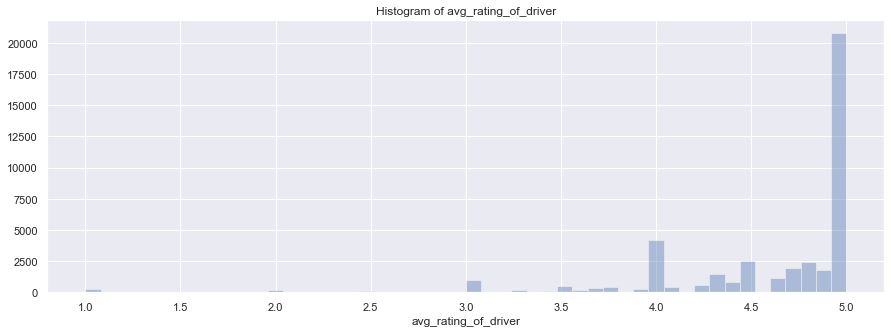

In [19]:
sns.distplot(
    df.avg_rating_of_driver, kde=False
)
plt.title("Histogram of avg_rating_of_driver")
plt.show()

The mean rating is 4.6:

In [25]:
df.avg_rating_of_driver.mean()

4.6015592912744685

Replacing missing values with mean values:

In [26]:
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(), inplace = True)

Same with avg_rating_by_driver: 

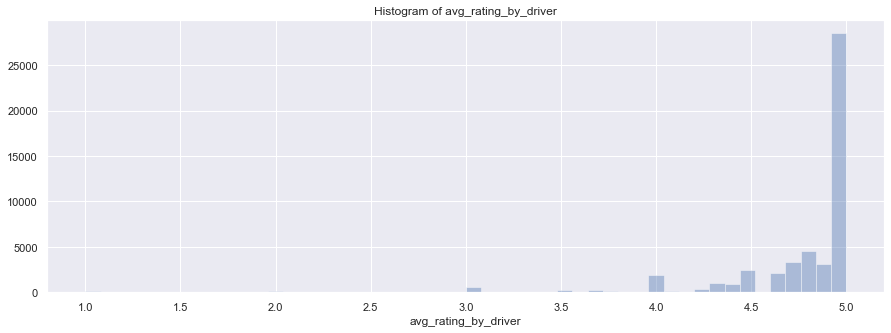

In [20]:
sns.distplot(
    df.avg_rating_by_driver, kde=False
)
plt.title("Histogram of avg_rating_by_driver")
plt.show()

In [21]:
df.avg_rating_by_driver.mean()

4.778158195947439

In [22]:
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(), inplace = True)

Next column with missing values is phones. Countplot looks like follows:

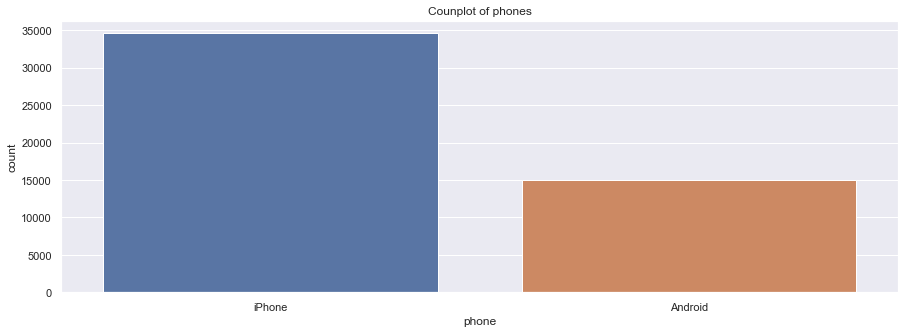

In [23]:
sns.countplot(x="phone", data=df)
plt.title("Counplot of phones")
plt.show()

Let's replace missing values with most frequent value:

In [27]:
df.phone.fillna(df.phone.value_counts().index[0], inplace = True)

Now let's check that we have no missinf values now:

In [28]:
sum(df.isnull().sum())

0

In [30]:
# transforming to datetime
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

Now let's define adopted users:

In [33]:
adopted_threshold =  max(df.last_trip_date) - pd.offsets.DateOffset(days=30)

In [34]:
df['adopted'] = df.last_trip_date <= adopted_threshold

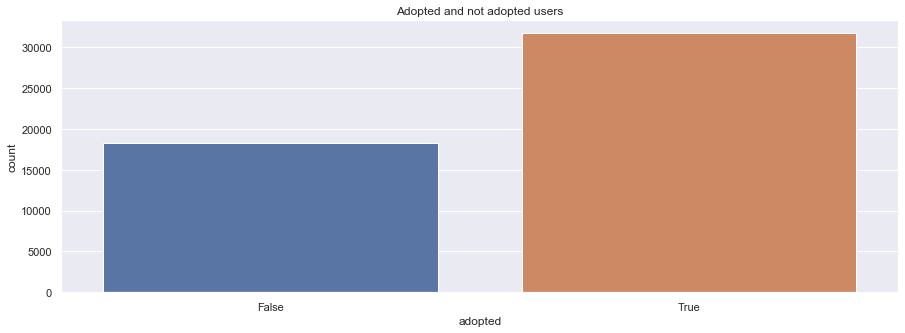

In [35]:
sns.countplot(x="adopted", data=df)
plt.title("Adopted and not adopted users")
plt.show()

In [230]:
df[df.adopted].count()/df.count()

city                      0.6338
trips_in_first_30_days    0.6338
signup_date               0.6338
avg_rating_of_driver      0.6338
avg_surge                 0.6338
last_trip_date            0.6338
phone                     0.6338
surge_pct                 0.6338
ultimate_black_user       0.6338
weekday_pct               0.6338
avg_dist                  0.6338
avg_rating_by_driver      0.6338
adopted                   0.6338
dtype: float64

0.63% of users are adopted.

Let's build predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system.

I'll use LGBMClassifier. Tree based models are easy to interpret in terms of variables importance, so let's see if a gradient boosting tree based method will work in our case. We are interested in variable importance, and methods like CNN don't provide easy interpretability.


First, let's bring variables types to the ones wee need for modeling:

In [36]:
df["last_trip_date"] = np.int64(pd.to_datetime(df["last_trip_date"], unit='s'))
df["signup_date"] = np.int64(pd.to_datetime(df["signup_date"], unit='s'))
df["city"] = df["city"].astype("category")
df["phone"] = df["phone"].astype("category")

Splitting to predictors and target variable:

In [37]:
X = df.drop(columns=['adopted', 'last_trip_date'])
y = df['adopted']

Modeling (with 5-fold cross-validation). Cross-validation will help our certainty about variable importance - that it's not just the property of particular run:

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import lightgbm as lgb
from lightgbm import LGBMClassifier

#splitting to train and validation datasets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#defining the model parameters:
model = LGBMClassifier(
    boosting_type="gbdt",
    n_estimators=20000,
    learning_rate=0.001,
    subsample=0.7,
    n_jobs=8,
)

In [40]:
#fitting cross-validated model
model_cv = cross_validate(
    estimator = model,
    X = X_train,
    y=y_train,
    cv = 5,
    n_jobs=8,
    return_estimator=True,
)

In [41]:
#accessing the validation score:
model_cv['test_score']

array([0.79771429, 0.78471429, 0.79357143, 0.79157143, 0.78914286])

In [42]:
np.mean(model_cv['test_score'])

0.7913428571428571

Mean test score is 0.79, which is pretty decent score to allow us to proceed with feature importance interpretation.

In [43]:
#building feature_importance array
feature_importance = [
    model_cv["estimator"][i].feature_importances_
    for i in range(0, len(model_cv["estimator"]))
]
feature_importance = pd.DataFrame(data=feature_importance, columns=X.columns)
feature_importance = feature_importance.reindex(
    feature_importance.mean().sort_values(ascending=False).index, axis=1
)

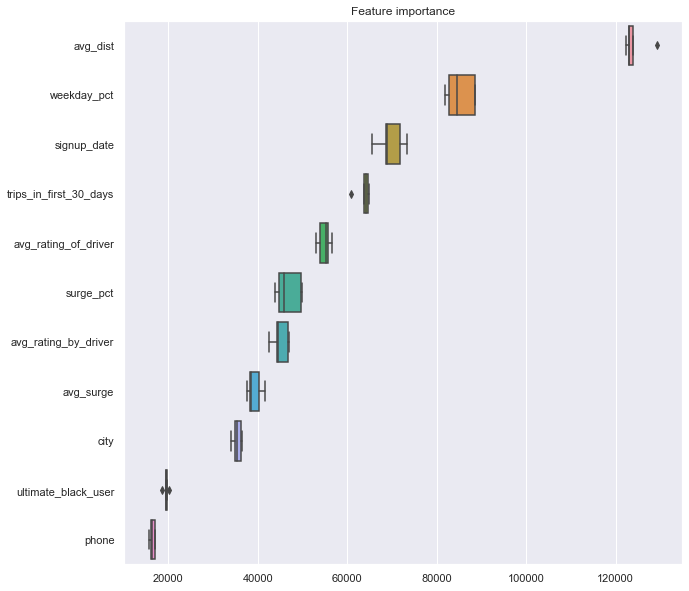

In [44]:
#plotting feature_importance plot
plt.figure(figsize=(10, 10))
sns.boxplot(data=feature_importance, orient="h")
plt.title("Feature importance")
plt.show()

As we can see from the plot, the most important are variables are 'avg_dist' and 'weekday_pct'. The least important are 'ultimate_black_user' and 'phone'. Let's take a look at the most important ones:

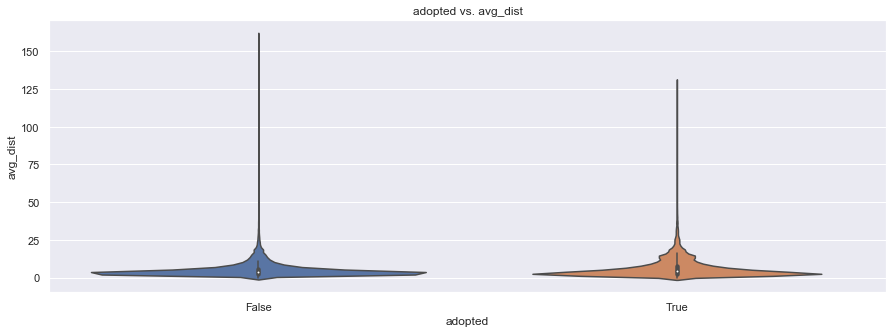

In [46]:
sns.violinplot(
    x="adopted", y="avg_dist", data=df,
)
plt.title("adopted vs. avg_dist")
plt.show()

In [54]:
df[df.adopted == True].avg_dist.mean()

6.1884777532344595

In [55]:
df[df.adopted == False].avg_dist.mean()

5.118977061714958

Adopted users travel larger distances. 

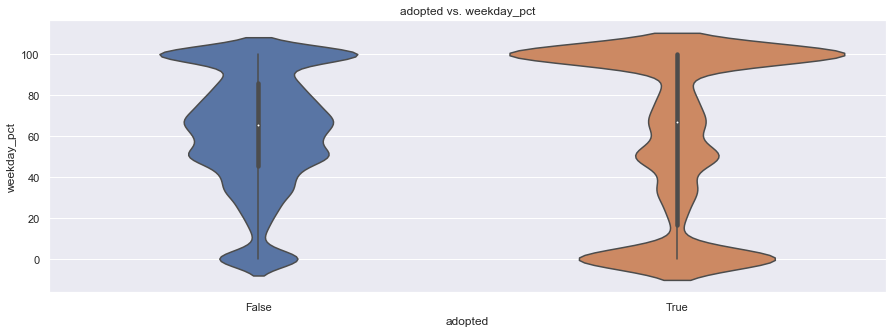

In [48]:
sns.violinplot(
    x="adopted", y="weekday_pct", data=df,
)
plt.title("adopted vs. weekday_pct")
plt.show()

Adopted users tend to have zero or opposite, 100% of trips occurring during a weekday. Not adopted users tend to have medium number of trips occurring during a weekday. It means, that adopted users use our service either during weekends, or during weekdays, but not a lot of mixed. Not adopted users use it more evenly during the week.

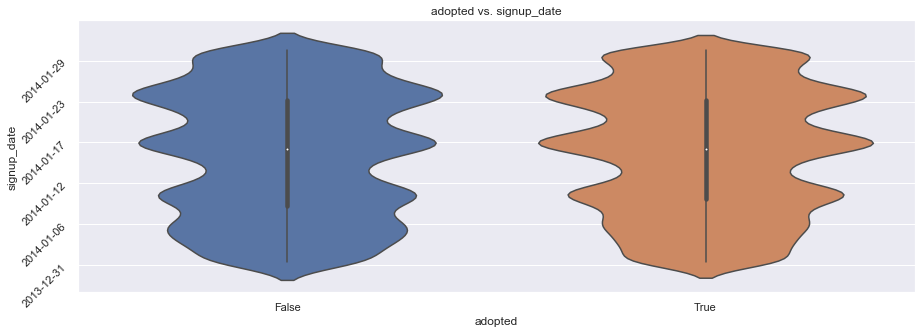

In [49]:
#building violin plot for signup_date
sns.violinplot(
    x="adopted",
    y=df.signup_date,
    data=df,
)
plt.title("adopted vs. signup_date")

# get current axis
ax = plt.gca()
# get current ytick labels
yticks = ax.get_yticks()
#convert all ytick labels to selected format from ms timestamp
ax.set_yticklabels([pd.to_datetime(tm).strftime('%Y-%m-%d') for tm in yticks],rotation=45)

plt.show()

Adopted users are happier with their drivers. 

_____________

The least important variables are ultimate_black_user and phone.

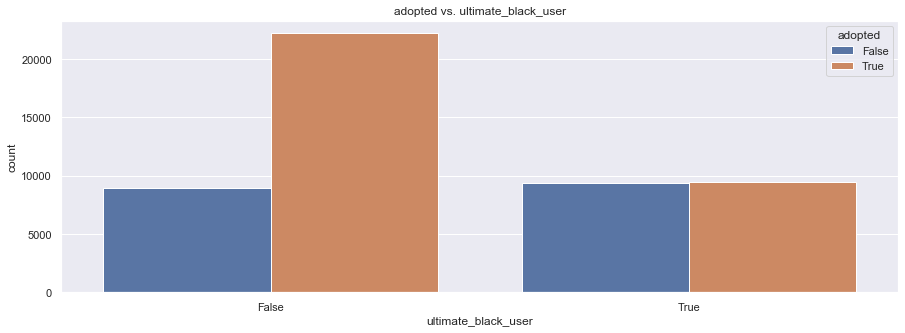

In [52]:
sns.countplot(x="ultimate_black_user", hue = 'adopted', data=df)
plt.title("adopted vs. ultimate_black_user")
plt.show()

ultimate_black_users are equally likely to be adopted or not. On the other hand, regular users are more likely to became adopted than not.

Interesting plot is for cities:
Users from King's Landing are more likely drop the service.

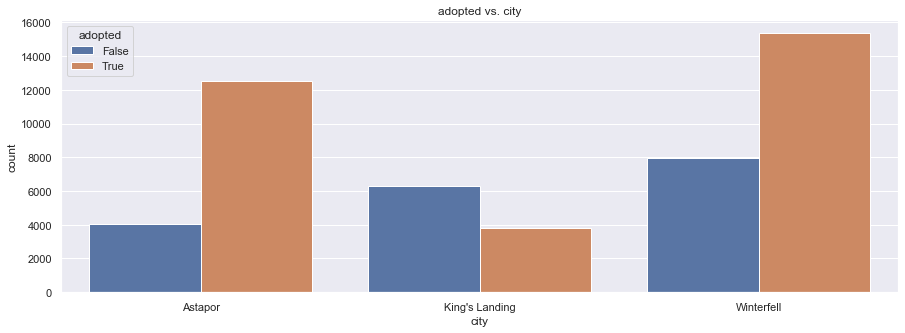

In [53]:
sns.countplot(hue="adopted", x = 'city', data=df)
plt.title('adopted vs. city')
plt.show()

As a recommendations, we can recommend paying special attention to users who travel smaller distances, and uses our service evenly both during the weekends and weekdays. We can offer them promotions.

Also, we might want to investigate what's wrong in King's Landing.